# Benchmark

This notebook evaluates the performance of tstore to read, write and store irregular geospatial time series data by comparing it to [xvec](https://github.com/xarray-contrib/xvec) (v0.3.0) and its [two recommended storage formats](https://xvec.readthedocs.io/en/v0.3.0/io.html), namely [netCDF](https://www.unidata.ucar.edu/software/netcdf/) and [Zarr](https://github.com/zarr-developers/zarr-python).

To that end, we will download meteorological observations from the [Automated Surface/Weather Observing Systems (ASOS/AWOS) program](https://www.ncei.noaa.gov/products/land-based-station/automated-surface-weather-observing-systems), which comprises more than 900 automated weather stations in the United States. More precisely, we will combine [the 1-minute ASOS data](https://madis.ncep.noaa.gov/madis_OMO.shtml) with the [ASOS Global METAR archive maintaned by the Iowa Environmental Mesonet (IEM)](https://mesonet.agron.iastate.edu/request/download.phtml), which features more weather stations but at a much coarser temporal resolution (~20 minutes).
We will use the [meteostations-geopy](https://github.com/martibosch/metastations-geopy) package to fetch the data. For this tutorial, you need to install the `feat-multivar-df` branch, e.g.:

```
pip install git+ssh://git@github.com/martibosch/meteostations-geopy.git@feat-multivar-df
```

In [ ]:
import os
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import xarray as xr
import xvec  # noqa: F401
from meteostations.clients import iem

import tstore

figwidth, figheight = plt.rcParams["figure.figsize"]


def plot_stations(client, ax=None, source=cx.providers.CartoDB.Voyager, **plot_kws):
    """Plot stations with a contextily basemap."""
    _plot_kws = plot_kws.copy()
    if ax is None:
        try:
            ax = _plot_kws.pop("ax")
        except KeyError:
            _, ax = plt.subplots()
    client.stations_gdf.plot(ax=ax, **_plot_kws)
    cx.add_basemap(ax, crs=client.stations_gdf.crs, source=source)
    return ax


def get_tstore_filepaths(base_dir):
    """Get filepaths of tstore files in a directory."""
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]

We will only consider the ASOS stations located within the state of Colorado, and we will download the temperature, pressure, precipitation and wind speed data (see the [meteostations-geopy variable notation](https://meteostations-geopy.readthedocs.io/en/latest/user-guide.html#selecting-variables)) for the 2021-2023 period (inclusive).

In [ ]:
region = "Colorado"
variables = ["temperature", "pressure", "precipitation", "surface_wind_speed"]
year_end = 2023
num_years = 3

## Get stations locations

Let us start by plotting the ASOS 1 minute and METAR/ASOS stations' locations:

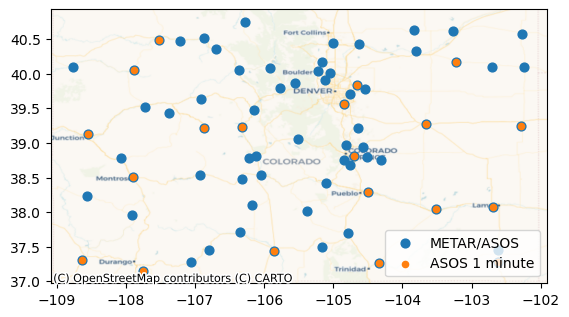

In [ ]:
metar_asos_client = iem.METARASOSIEMClient(region)
onemin_client = iem.ASOSOneMinIEMClient(region)

fig, ax = plt.subplots()
labels = ["METAR/ASOS", "ASOS 1 minute"]
colors = sns.color_palette(n_colors=2)
sizes = [40, 20]
for client, color, size, label in zip(
    [metar_asos_client, onemin_client],
    colors,
    sizes,
    labels,
):
    plot_stations(client, ax=ax, color=color, label=label, markersize=size)
ax.legend()

As we can see, not all the METAR/ASOS stations have 1 minute data. Accordingly, for the stations that have 1 minute data, we will use the 1 minute data only (that is, we will not query the METAR/ASOS data for those stations), and for the rest, we will use the METAR/ASOS data.

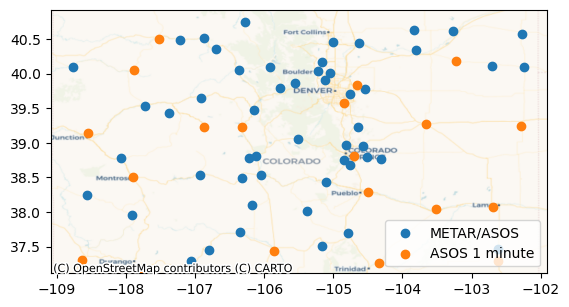

In [ ]:
metar_asos_stations_gdf = metar_asos_client.stations_gdf.copy()[
    ~metar_asos_client.stations_gdf[metar_asos_client._stations_id_col].isin(
        onemin_client.stations_gdf[metar_asos_client._stations_id_col],
    )
]
# ACHTUNG: ideally we should implement a proper `setter` for the `stations_gdf` property in meteostations-geopy
metar_asos_client._stations_gdf = metar_asos_stations_gdf

# plot again
fig, ax = plt.subplots()
for client, color, label in zip([metar_asos_client, onemin_client], colors, labels):
    plot_stations(client, ax=ax, color=color, label=label)
ax.legend()

## Get time series of observations

We will now proceed to downloading the time series of observations

In [ ]:
# date period and frequency to chunk requests
end = datetime(year=year_end, month=12, day=31)
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

date_range = pd.date_range(
    end - timedelta(days=365 * num_years),
    end + timedelta(days=31),
    freq=freq,
)

In [ ]:
def get_ts_df(client, variables, date_range):
    """Get time series data frame for a date range."""
    ts_df = pd.concat(
        [
            client.get_ts_df(variables, start_date, end_date)
            for start_date, end_date in tqdm.tqdm(
                zip(date_range[:-1], date_range[1:]),
                total=len(date_range) - 1,
            )
        ],
    )
    # rename time column so that they both have a common label
    ts_df.index = ts_df.index.rename({client._time_col: "time"})
    return ts_df


metar_asos_ts_df = get_ts_df(metar_asos_client, variables, date_range)
onemin_ts_df = get_ts_df(onemin_client, variables, date_range)

100%|█████████████████████████████████████████████████| 36/36 [00:44<00:00,  1.23s/it]


This is what the time series data frames look like:

In [ ]:
metar_asos_ts_df

temperature  pressure  precipitation  \
station time                                                        
04V     2021-01-01 00:15:00         21.2       NaN            0.0   
        2021-01-01 00:35:00         21.2       NaN            0.0   
        2021-01-01 00:55:00         19.4       NaN            0.0   
        2021-01-01 01:15:00         19.4       NaN            0.0   
        2021-01-01 01:35:00         21.2       NaN            0.0   
...                                  ...       ...            ...   
VTP     2023-12-31 22:35:00         30.2       NaN            0.0   
        2023-12-31 22:55:00         32.0       NaN            0.0   
        2023-12-31 23:15:00         30.2       NaN            0.0   
        2023-12-31 23:35:00         30.2       NaN            0.0   
        2023-12-31 23:55:00         30.2       NaN            0.0   

                             surface_wind_speed  
station time                                     
04V     2021-01-01 00:15:00                 3.0  
        2021-01-01 00:35:00                 4.0  
        2021-01-01 00:55:00                 5.0  
        2021-01-01 01:15:00                 6.0  
        2021-01-01 01:35:00                 5.0  
...                                         ...  
VTP     2023-12-31 22:35:00                 0.0  
        2023-12-31 22:55:00                 3.0  
        2023-12-31 23:15:00                 0.0  
        2023-12-31 23:35:00                 0.0  
        2023-12-31 23:55:00                 3.0  

[4901787 rows x 4 columns]

In [ ]:
onemin_ts_df

temperature  pressure  precipitation  \
station time                                                        
AKO     2021-01-01 07:00:00         20.0    25.301            0.0   
        2021-01-01 07:01:00         20.0    25.300            0.0   
        2021-01-01 07:02:00         21.0    25.300            0.0   
        2021-01-01 07:03:00         21.0    25.300            0.0   
        2021-01-01 07:04:00         21.0    25.300            0.0   
...                                  ...       ...            ...   
TAD     2023-12-31 23:55:00         35.0    24.379            0.0   
        2023-12-31 23:56:00         35.0    24.379            0.0   
        2023-12-31 23:57:00         35.0    24.379            0.0   
        2023-12-31 23:58:00         35.0    24.380            0.0   
        2023-12-31 23:59:00         35.0    24.380            0.0   

                             surface_wind_speed  
station time                                     
AKO     2021-01-01 07:00:00                 9.0  
        2021-01-01 07:01:00                 9.0  
        2021-01-01 07:02:00                 9.0  
        2021-01-01 07:03:00                 9.0  
        2021-01-01 07:04:00                 9.0  
...                                         ...  
TAD     2023-12-31 23:55:00                 5.0  
        2023-12-31 23:56:00                 5.0  
        2023-12-31 23:57:00                 5.0  
        2023-12-31 23:58:00                 5.0  
        2023-12-31 23:59:00                 5.0  

[28669682 rows x 4 columns]

Let us now combine and preprocess the two time seires data frames and station locations geo-data frames:

In [ ]:
# merge the two data frames, reset the index, and set the station id as a string with the name "id" (so that it is the
# same as the stations geo data frame)
ts_df = pd.concat([onemin_ts_df, metar_asos_ts_df]).reset_index()
# TODO: https://github.com/wesm/feather/issues/349
ts_df = ts_df.assign(**{"id": ts_df["station"].astype(str)}).drop(columns=["station"])

# merge the stations geo data frames too and keep only the columns of interest
stations_gdf = pd.concat(
    [onemin_client.stations_gdf, metar_asos_client.stations_gdf],
).reset_index()[["id", "geometry"]]

# TODO: https://github.com/wesm/feather/issues/349
stations_gdf["id"] = stations_gdf["id"].astype(str)

## TStore

We will start by writing the data into a tstore:

In [ ]:
# tstore arguments
tstore_dir = "colorado-tstore"
id_var = "id"
time_var = "time"
partitioning = "year"
tstore_structure = "id-var"

# init tstore
tslong = tstore.TSLong(
    ts_df,
    id_var=id_var,
    time_var=time_var,
    geometry=stations_gdf,
)

# dump
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # TSTORE options
    partitioning=partitioning,
    tstore_structure=tstore_structure,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 13.30 s


This is the resulting file structure:

In [ ]:
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB")

colorado-tstore/tstore_metadata.yaml
colorado-tstore/_attributes.parquet
colorado-tstore/8V7/ts_variable/_common_metadata
colorado-tstore/8V7/ts_variable/_metadata
colorado-tstore/8V7/ts_variable/year=2023/part-0.parquet
...
colorado-tstore/33V/ts_variable/_common_metadata
colorado-tstore/33V/ts_variable/_metadata
colorado-tstore/33V/ts_variable/year=2021/part-0.parquet
colorado-tstore/33V/ts_variable/year=2022/part-0.parquet
colorado-tstore/33V/ts_variable/year=2023/part-0.parquet
Total size: 328.56346 MB


The advantage of tstore is that each station id has a dedicated directory so there is no need to "align" data with different temporal resolutions.

Let us now see how long it takes to read back the whole data:

In [ ]:
start = time.time()
ts_roundtrip_df = tstore.open_tslong(tstore_dir, backend="pandas")
print(f"Read tstore in: {time.time() - start:.2f} s")

Read tstore in: 12.10 s


and reading only one year:

In [ ]:
start = time.time()
ts_2023_df = tstore.open_tslong(
    tstore_dir,
    start_time="2023-01-01",
    end_time="2024-01-01",
    inclusive="left",
    backend="pandas",
)
print(f"Read tstore for one year in: {time.time() - start:.2f} s")
ts_2023_df

Read tstore for one year in: 4.02 s


,id,temperature,pressure,precipitation,surface_wind_speed,time
0,C08,37.4,<NA>,0.0,4.0,2023-09-27 10:55:00
1,C08,35.6,<NA>,0.0,4.0,2023-09-27 11:15:00
2,C08,37.4,<NA>,0.0,3.0,2023-09-27 12:15:00
3,C08,33.8,<NA>,0.0,6.0,2023-09-27 12:35:00
4,C08,35.6,<NA>,0.0,6.0,2023-09-27 12:55:00
...,...,...,...,...,...,...
11035206,CAG,34.0,24.085,0.0,4.0,2023-10-14 02:10:00
11035207,CAG,34.0,24.085,0.0,4.0,2023-10-14 02:11:00
11035208,CAG,33.0,24.085,0.0,4.0,2023-10-14 02:12:00
11035209,CAG,33.0,24.086,0.0,4.0,2023-10-14 02:13:00


Again, we can lazily read the whole tstore into a tsdf object:

In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf

,id,ts_variable,geometry
0,AKO,Dask DataFrame Structure: ...,POINT (-103.22200 40.17560)
1,ALS,Dask DataFrame Structure: ...,POINT (-105.86140 37.43890)
2,APA,Dask DataFrame Structure: ...,POINT (-104.85000 39.57000)
3,ASE,Dask DataFrame Structure: ...,POINT (-106.86890 39.22320)
4,CAG,Dask DataFrame Structure: ...,POINT (-107.52160 40.49520)
...,...,...,...
67,4V1,Dask DataFrame Structure: ...,POINT (-104.78810 37.69410)
68,AIB,Dask DataFrame Structure: ...,POINT (-108.56330 38.23880)
69,SHM,Dask DataFrame Structure: ...,POINT (-104.51670 38.80000)
70,C08,Dask DataFrame Structure: t...,POINT (-105.37430 38.01330)


and perform computations lazily, e.g., plot stations by their mean temperature:

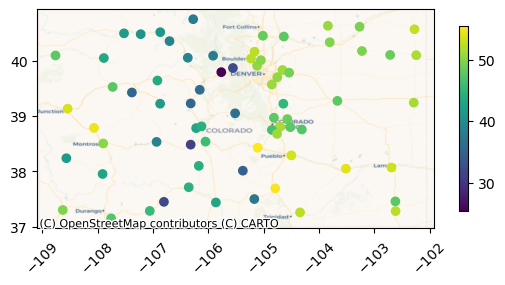

In [ ]:
mean_t_ser = tsdf["ts_variable"].apply(
    lambda ts: ts._obj["temperature"].mean().compute(),
)

ax = tsdf.plot(mean_t_ser, legend=True, legend_kwds={"shrink": 0.5})
cx.add_basemap(ax=ax, crs=stations_gdf.crs, source=cx.providers.CartoDB.Voyager)
ax.tick_params(axis="x", labelrotation=45)

## xvec

Let us now see how we can transform our dataset into a vector data cube using xvec:

In [ ]:
ts_ds = ts_df.set_index([id_var, time_var]).to_xarray()
# TODO: how to keep both the stations ids and geometries?
ts_ds = (
    ts_ds.assign_coords(
        **{
            id_var: stations_gdf.set_index(id_var).loc[ts_ds[id_var].values][
                "geometry"
            ],
        },
    )
    .rename({id_var: "geometry"})
    .xvec.set_geom_indexes("geometry", crs=stations_gdf.crs)
)
ts_ds

<xarray.Dataset> Size: 4GB
Dimensions:             (geometry: 72, time: 1541841)
Coordinates:
  * time                (time) datetime64[ns] 12MB 2021-01-01 ... 2023-12-31T...
  * geometry            (geometry) object 576B POINT (-106.17 38.1) ... POINT...
Data variables:
    temperature         (geometry, time) float64 888MB nan nan nan ... nan nan
    pressure            (geometry, time) float64 888MB nan nan nan ... nan nan
    precipitation       (geometry, time) float64 888MB nan nan nan ... nan nan
    surface_wind_speed  (geometry, time) float64 888MB nan nan nan ... nan nan
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

The main issue is that the vector data cube structure needs the "time" dimension to be aligned, which will result in many NaN values for the METAR stations due to the temporal resolution mismatch.

In [ ]:
print("Memory usage")
for label, n_bytes in zip(
    ["pandas.DataFrame (long):", "xarray.Dataset:"],
    [ts_df.memory_usage(index=True).sum(), ts_ds.nbytes],
):
    print(label, n_bytes / 1e6, "MB")

Memory usage
pandas.DataFrame (long): 1611.430644 MB
xarray.Dataset: 3564.736968 MB


In any case, let us now evaluate the read/write operations as well as disk storage sizes. Let us first define the following variables to partition by year like in tstore:

In [ ]:
# year_len = len(ts_2023_df.index)
year_len = int(len(ts_df) / num_years)
year_slice = slice("2023-01-01", "2023-12-31")

### netCDF

In [ ]:
nc_filepath = "colorado.nc"

start = time.time()
# ACHTUNG: this requires xvec >= 0.3.0
ts_ds.chunk({time_var: year_len}).xvec.encode_cf().to_netcdf(nc_filepath)
print(
    f"Dumped netcdf in: {time.time() - start:.2f} s, {path.getsize(nc_filepath)/1e6} MB",
)
start = time.time()
ts_roundtrip_ds = xr.open_dataset(nc_filepath).xvec.decode_cf().compute()
print(f"Read netcdf in: {time.time() - start:.2f} s")
start = time.time()
ts_2023_ds = (
    xr.open_dataset(nc_filepath)
    .xvec.decode_cf()
    .sel(**{time_var: year_slice})
    .compute()
)
print(f"Read netcdf (1 year) in: {time.time() - start:.2f} s")

Dumped netcdf in: 11.97 s, 3564.767297 MB
Read netcdf in: 22.04 s
Read netcdf (1 year) in: 7.13 s


### zarr

In [ ]:
zarr_dir = "colorado.zarr"

start = time.time()
# ACHTUNG: this requires xvec >= 0.3.0
ts_ds.chunk({time_var: year_len}).xvec.encode_cf().to_zarr(zarr_dir)
print(f"Dumped zarr in: {time.time() - start:.2f} s")
zarr_filepaths = get_tstore_filepaths(zarr_dir)
zarr_size = sum(path.getsize(zarr_filepath) for zarr_filepath in zarr_filepaths)
print(f"Total size: {zarr_size/1e6} MB")
start = time.time()
ts_roundtrip_ds = xr.open_zarr(zarr_dir).xvec.decode_cf().compute()
print(f"Read zarr in: {time.time() - start:.2f} s")
start = time.time()
ts_2023_ds = (
    xr.open_zarr(zarr_dir).xvec.decode_cf().sel(**{time_var: year_slice}).compute()
)
print(f"Read zarr (1 year) in: {time.time() - start:.2f} s")

Dumped zarr in: 6.95 s
Total size: 236.047886 MB
Read zarr in: 7.76 s
Read zarr (1 year) in: 5.49 s


Let us make sure that the data has been read correctly:

In [ ]:
ts_2023_ds

<xarray.Dataset> Size: 1GB
Dimensions:             (geometry: 72, time: 513896)
Coordinates:
  * geometry            (geometry) object 576B POINT (-106.17 38.1) ... POINT...
  * time                (time) datetime64[ns] 4MB 2023-01-01 ... 2023-12-31T2...
Data variables:
    precipitation       (geometry, time) float64 296MB nan nan nan ... nan nan
    pressure            (geometry, time) float64 296MB nan nan nan ... nan nan
    surface_wind_speed  (geometry, time) float64 296MB nan nan nan ... nan nan
    temperature         (geometry, time) float64 296MB nan nan nan ... nan nan
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

Finally, let us plot the stations again by mean temperature but this time using xvec:

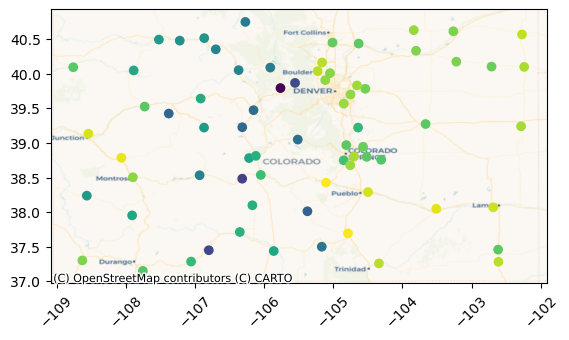

In [ ]:
mean_t_da = ts_ds["temperature"].mean("time")

ax = mean_t_da.xvec.to_geodataframe().plot("temperature")
cx.add_basemap(ax=ax, crs=stations_gdf.crs, source=cx.providers.CartoDB.Voyager)
ax.tick_params(axis="x", labelrotation=45)